In [15]:
from __future__ import print_function

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Dataset,DataLoader
from torchvision import utils

import copy

import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Utils to show Tensor Image
unloader = transforms.ToPILImage()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image, cmap="gray")
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [4]:
class colorizationDataset(Dataset):
    def __init__(self, root=None, tf=None):
        self.grey = np.load("./image-colorization/gray_scale.npy") # get your numpy array paths here
        self.grey = torch.from_numpy(self.grey)
        
        self.color = np.load("./image-colorization/ab/ab1.npy")
        self.color = np.concatenate((self.color,np.load("./image-colorization/ab/ab2.npy")))
        self.color = np.concatenate((self.color,np.load("./image-colorization/ab/ab3.npy")))
        self.color = torch.from_numpy(self.color)
        #print(self.images.shape)
        #self.images = self.toPyTensor()
        #print(self.images.shape)

    def __getitem__(self, index):
        return (self.grey[index],self.color[index])
    
    def __len__(self):
        return len(self.grey)
    
    def transformations(self,tf=None):
        if tf is None:
            tf = transforms.ToTensor()
        return tf(self.grey)

# Create Dataset of grey-colored images
dataset = colorizationDataset()



Dataset Length:  25000
Each grayscale image is size:  torch.Size([224, 224])
Each color image is size:  torch.Size([224, 224, 2])
Image data type:  torch.uint8 cpu
Sample image: tensor([[237, 135,  75,  ...,  35,  37,  63],
        [234, 152,  72,  ...,  41,  49,  47],
        [215, 216, 104,  ...,  73,  48,  82],
        ...,
        [ 40,  45,  38,  ...,  11,   8,   8],
        [ 40,  56,  47,  ...,   8,   7,  10],
        [ 42,  60,  79,  ...,  12,  13,  15]], dtype=torch.uint8)
<class 'numpy.ndarray'>


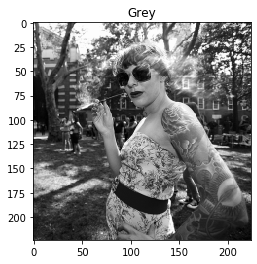

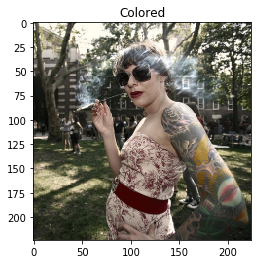

In [5]:
# Dataset Stats
grey, color = dataset[0]
print("Dataset Length: ", len(dataset))
print("Each grayscale image is size: ", grey.shape)
print("Each color image is size: ", color.shape)
print("Image data type: ", grey.dtype , grey.device)
print("Sample image:", grey)
plt.title("Grey")
plt.imshow(grey, cmap="gray")

# Recreating RGB image using the L and AB from the dataset


def toRGB(grey,color):
    # Initializing with zeros ( or any random number)
    img = np.zeros((224, 224, 3))
    img[:, :, 0] = grey
    img[:, :, 1:] = color
    img = img.astype('uint8')
    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img_

# Convert to RGB Space to plot it
plt.figure()
plt.title("Colored")
img_ = toRGB(grey,color)
plt.imshow(img_)
print(type(img_))


Batch:  2


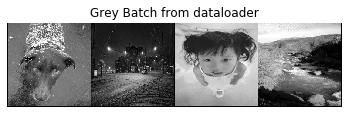

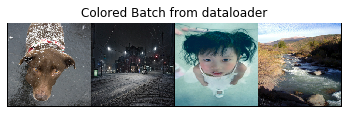

In [6]:
# Helper function to show a batch
def show_images_batch(sample_batched):
    """Show image for a batch of samples."""
    greys_batch, color_batch = \
            sample_batched[0], sample_batched[1]
    
    batch_size = len(greys_batch)
    #print(batch_size)
    im_size = greys_batch.size(2)
    #print(im_size)
    grid_border_size = 2

    greys_batch = greys_batch.unsqueeze(3)
    #print("Greys batch: ",greys_batch.shape)
    #print("Color batch: ",color_batch.shape)
    
    combined = torch.cat((greys_batch,color_batch),3)
    #print("Combined: ", combined.shape)

    plt.figure()
    grid = utils.make_grid(greys_batch.permute(0,3,1,2))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Grey Batch from dataloader')
    plt.axis('off')
    
    
    colored = []
    for i in range(batch_size):
        colored.append(torch.from_numpy( cv2.cvtColor(combined[i].numpy(), cv2.COLOR_LAB2RGB) ) )

    # Combine list of Tensor into a single Tensor
    color = torch.stack(colored)
    #print("Color Stack: ", type(color), color.shape)
    
    plt.figure()
    grid2 = utils.make_grid(color.permute(0,3,1,2))
    plt.imshow(grid2.numpy().transpose(1,2,0))
    plt.title('Colored Batch from dataloader')
    plt.axis('off')

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)
   
for i_batch, sample_batched in enumerate(dataloader):
   # print(i_batch, sample_batched[0].shape,
     #     sample_batched[1].shape)
    
    # observe 1th batch and stop.
    if i_batch == 2:
        print("Batch: ",i_batch)
        
        #plt.figure()
        show_images_batch(sample_batched)
        #plt.axis('off')
        #plt.ioff()
        #plt.show()
        break
    

In [7]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 224*224
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 224*224)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, 224, 224)

In [8]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 224*224
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [9]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [10]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 50

In [11]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data


In [12]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error



In [19]:
for epoch in range(num_epochs):
    for n_batch, (real_batch_grey,real_batch_color) in enumerate(dataloader):

        # 1. Train Discriminator
        real_data_grey = Variable(images_to_vectors(real_batch_grey))
        real_data_color = Variable(images_to_vectors(real_batch_color))
        if torch.cuda.is_available(): real_data_grey = real_data_grey.cuda()
        if torch.cuda.is_available(): real_data_color = real_data_color.cuda()
            
        # Generate fake data
        fake_data = generator(real_batch_grey)#noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        #logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            #logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            #logger.display_status(
            #    epoch, num_epochs, n_batch, num_batches,
            #    d_error, g_error, d_pred_real, d_pred_fake
            #)
        # Model Checkpoints
        #logger.save_models(generator, discriminator, epoch)

RuntimeError: shape '[4, 50176]' is invalid for input of size 401408

In [27]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           U-NET
##############################


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [26]:
gan = GAN()

TypeError: __init__() missing 1 required positional argument: 'out_features'

In [ ]:
class GAN():
    def __init__(self):
        self.img_rows = 224
        self.img_cols = 224
        self.in_channels = 1
        self.out_channels = 3
        
        self.img_shape = (self.img_rows, self.img_cols, self.in_channels)

        
        # Build the generator
        self.generator = self.build_generator()

    
        self.optimizer = optim.Adam(self.generator.parameters(), lr=0.0002,betas=(0.5,0.99))

    def build_generator(self):
        model = nn.Sequential(nn.Linear(256,512),
                              nn.LeakyReLU(negative_slope=0.2),
                              nn.BatchNorm2d(512),
                              nn.Linear(512,1024),
                              nn.LeakyReLU(negative_slope=0.2),
                              nn.BatchNorm2d(1024),
                              nn.Linear(1024,np.prod(self.img_shape)),
                              nn.LeakyReLU(negative_slope=0.2),
                              nn.BatchNorm2d(np.prod(self.img_shape)),
                              nn.Linear(np.prod(self.img_shape)),
                              nn.TanH()
                              
                             )
        return model